# XRoration (XGate) - hls4ml

## Configuration

Pulse and fidelity computation are computation intensive (slow).

In [1]:
PULSE_ENABLED = False
FIDELITY_ENABLED = True

Parameters are stored in a shared script.

In [2]:
from parameters import *

## Library

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import qkeras
#from tensorflow.keras.models import load_model

import sys
sys.path.append('..')

from utils.helpers import *
from utils.plotting import *

# Disable some console warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2024-04-20 15:45:12.851477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Check GPU

## Dataset

### Load

In [4]:
x_train = np.load('./data/xrotation/{}/x_train.npy'.format(CSV_CONFIG), allow_pickle=True)
x_val = np.load('./data/xrotation/{}/x_val.npy'.format(CSV_CONFIG), allow_pickle=True)
x_test = np.load('./data/xrotation/{}/x_test.npy'.format(CSV_CONFIG), allow_pickle=True)
y_train = np.load('./data/xrotation/{}/y_train.npy'.format(CSV_CONFIG), allow_pickle=True)
y_val = np.load('./data/xrotation/{}/y_val.npy'.format(CSV_CONFIG), allow_pickle=True)
y_test = np.load('./data/xrotation/{}/y_test.npy'.format(CSV_CONFIG), allow_pickle=True)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [6]:
N_ANGLES = x_train.shape[1]
N_PARAMS = y_train.shape[1]

In [7]:
print('---------------------------------------')
print('- Pulse parameters (y) #', N_PARAMS) # ASSUMING 1 BETA VALUE (ANGLE ALONG X AXIS)
print('- Gate parameters  (x) #', N_ANGLES) # ASSUMING 1 BETA VALUE (ANGLES ALONG X AXIS)
print('---------------------------------------')

---------------------------------------
- Pulse parameters (y) # 5
- Gate parameters  (x) # 1
---------------------------------------


## hls4ml

- Vivado 2020.1 or greater
- RFSoC parts (engineering sample)

### Load Keras Model

In [8]:
best_model_file = PREFIX + '/best_keras_model.h5'
def sine_activation(x):
    return tf.math.sin(x)
model = tf.keras.models.load_model(best_model_file, custom_objects={'sine_activation': sine_activation})

In [9]:
model_id = MODEL_ID_PREFIX + get_basic_id(model)
print(model_id)

smallMLP_1x4x5


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (Dense)                 (None, 4)                 8         
                                                                 
 relu0 (Activation)          (None, 4)                 0         
                                                                 
 fc1 (Dense)                 (None, 5)                 25        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


### Load QKeras Model

In [11]:
best_model_file = PREFIX + '/best_qkeras_model.h5'
co = {}
qkeras.utils._add_supported_quantized_objects(co)
qmodel = tf.keras.models.load_model(best_model_file, custom_objects=co)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
qmodel_id = MODEL_ID_PREFIX + get_basic_id(qmodel)
print(qmodel_id)

smallMLP_1x4x5


In [13]:
qmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc0 (QDense)                (None, 4)                 8         
                                                                 
 relu0 (QActivation)         (None, 4)                 0         
                                                                 
 fc1 (QDense)                (None, 5)                 25        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


### Convert model

In [14]:
import hls4ml

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/home/mb4989/miniconda3/envs/ml-qubit-control-env/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [15]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.8.1


Set a bit-precision for the hardware implementation.


<span style="background-color:orange">Accumulators and layers outputs may be oversized, but it is a starting point.</span>

In [16]:
#import plotting

hconfig = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
#plotting.print_dict(hconfig)

Interpreting Sequential
Topology:
Layer name: fc0_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc0, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc1, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 5]


In [17]:
#import plotting

#best_model_file = PREFIX + '/best_qkeras_model.h5'
#qmodel = tf.keras.models.load_model(best_model_file)
#co = {}
#qkeras.utils._add_supported_quantized_objects(co)
#qmodel = tf.keras.models.load_model(best_model_file, custom_objects=co)
#plotting.print_dict(hconfig)

In [18]:
# Rounding and saturation for all of the activation functions (older hls4ml versions)
#hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
#hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
#hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
W = 21
I = 5
resuse = 20
# Rounding and saturation for all of the activation functions
hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
    layers=['Activation'],
    rounding_mode='AP_RND_CONV',
    saturation_mode='AP_SAT')

hconfig['Model']['ReuseFactor'] = resuse
#hconfig['Model']['Strategy'] = 'Resource'
hconfig['Model']['Precision'] = f"ap_fixed<{W},{I}>"
hconfig['LayerName']['fc0_input']['Precision']['result'] = f"ap_fixed<{W},{I}>"

for i, n in enumerate(NEURONS_PER_LAYER):
    hconfig['LayerName']['fc{}'.format(i)]['ReuseFactor'] = n
    hconfig['LayerName']['fc{}'.format(i)]['Precision']['result'] = f"ap_fixed<{W},{I}>"
    hconfig['LayerName']['fc{}'.format(i)+'_linear']['Precision']['result'] = f"ap_fixed<{W},{I}>"
    hconfig['LayerName']['relu{}'.format(i)]['Precision']['result'] = f"ap_fixed<{W},{I}>"

hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))]['ReuseFactor'] = resuse
hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))]['Precision']['result'] = f"ap_fixed<{W},{I}>"

hconfig['LayerName']['fc{}'.format(len(NEURONS_PER_LAYER))+'_linear']['Precision']['result'] = f"ap_fixed<{W},{I}>"


Show hls4ml configuration.

In [19]:
print_dict(hconfig)

Model
  Precision:         ap_fixed<21,5>
  ReuseFactor:       20
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  fc0_input
    Trace:           False
    Precision
      result:        ap_fixed<21,5>
  fc0
    Trace:           False
    Precision
      result:        ap_fixed<21,5>
      weight:        fixed<21,6>
      bias:          fixed<21,6>
    ReuseFactor:     4
  fc0_linear
    Trace:           False
    Precision
      result:        ap_fixed<21,5>
  relu0
    Trace:           False
    Precision
      result:        ap_fixed<21,5>
  fc1
    Trace:           False
    Precision
      result:        ap_fixed<21,5>
      weight:        fixed<21,6>
      bias:          fixed<21,6>
    ReuseFactor:     20
  fc1_linear
    Trace:           False
    Precision
      result:        ap_fixed<21,5>


In [20]:
# Enable tracing for all of the layers
for layer in hconfig['LayerName'].keys():
    print('Enable tracing for layer:', layer)
    hconfig['LayerName'][layer]['Trace'] = True

Enable tracing for layer: fc0_input
Enable tracing for layer: fc0
Enable tracing for layer: fc0_linear
Enable tracing for layer: relu0
Enable tracing for layer: fc1
Enable tracing for layer: fc1_linear


In [21]:
hmodel = hls4ml.converters.convert_from_keras_model(qmodel,
                                                    hls_config=hconfig,
                                                    output_dir=PREFIX+'hls4ml_prj',
                                                    part='xczu49dr-ffvf1760-2-e-es1') # ZCU216, engineering sample
                                                    #part='xczu49dr-ffvf1760-2-e') # ZCU216
                                                    #part='xczu3eg-sbva484-1-e')
                                                    #part='xc7a100t-csg324-3')

Interpreting Sequential
Topology:
Layer name: fc0_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: fc0, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: fc1, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 5]
Creating HLS model


Show hls4ml configuration (as before but graphical).

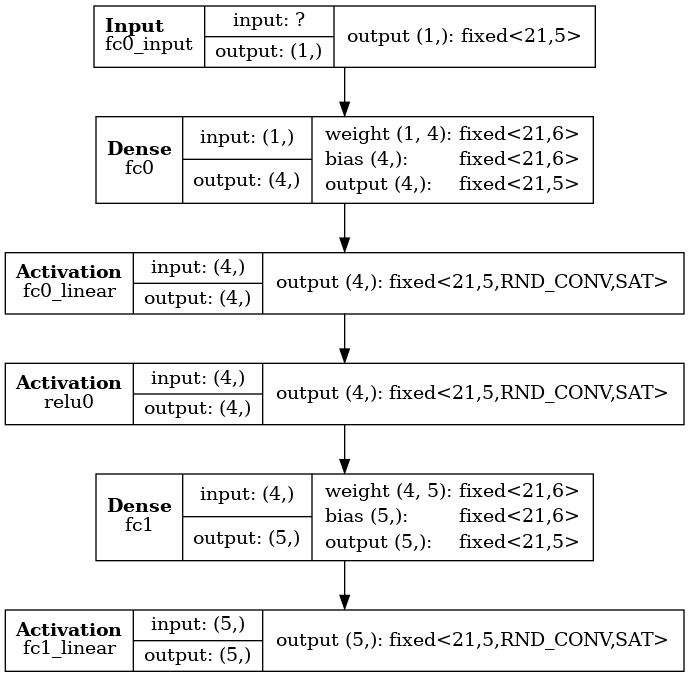

In [22]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

In [23]:
hmodel.compile()

Writing HLS project
Done


##### Tracing and debugging

In [24]:
# Run tracing on the test set for the hls4ml model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hmodel.trace(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))#, write_project=True)

Recompiling myproject with tracing
Writing HLS project
Done


In [25]:
# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(qmodel, x_test)

AttributeError: 'quantized_relu' object has no attribute '__name__'

You can visualize traces of the hls4ml model and compare them with Keras and QKeras models.

In [26]:
print(hls4ml_trace['fc0'][100])

[ 1.6769562  -0.6009674   0.39401245  0.09269714]


In [27]:
print(hls4ml_trace['relu0'][100])

[1.6769562  0.         0.39401245 0.09269714]


In [28]:
print(hls4ml_trace['fc1'][100])

[ 0.00125122 -0.00334167 -0.01083374 -0.00601196 -0.00527954]


In [ ]:
print(keras_trace['fc0'][100])

In [ ]:
print(keras_trace['relu0'][100])

In [ ]:
print(keras_trace['fc1'][100])

Compare the traces of the QKeras and hls4ml models. When converting a model from QKeras to hls4ml, the precision of the weights and biases is **automatically** imported. Instead, the designer has to **manually tune** the precision of the accumulators and outputs for each layer. See the previous section [Convert model](#Convert-model).

In [29]:
for layer in hls4ml_trace.keys():
    if '_linear' in layer:
        continue
        #klayer = layer.replace('_linear', '')
    plt.figure()
    klayer = layer
    plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
    max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    #plt.savefig(os.path.join(hmodel_prefix + '_' + str(run_id) + '_vivado_prj', 'profiling_{}.png'.format(layer)), dpi=300)

NameError: name 'keras_trace' is not defined

<Figure size 640x480 with 0 Axes>

### Evaluation

In [30]:
from utils.metrics import hls4ml_evaluate

In [31]:
def eval_local_mse(a, b):
    assert(len(a)==len(b))
    M=len(a)
    accum = 0
    for i in range(len(a)):
        accum += (a[i]-b[i])**2
    return accum/len(a)

def hls4ml_evaluate(model, x_test, Y_test):
    import numpy as np
    assert(len(x_test)==len(Y_test))
    N=len(x_test)
    accum = 0
    for i in range(N):
        expected = Y_test[i:i+1][0]
        predicted = model.predict(np.ascontiguousarray(x_test[i]))
        accum += eval_local_mse(expected, predicted)
    return accum / len(x_test)

In [32]:
hmse = hls4ml_evaluate(hmodel, x_test, y_test)

In [33]:
y_hls4ml = hmodel.predict(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))

In [34]:
import random
hash_id = random.getrandbits(32)
    
if FIDELITY_ENABLED:
    xgate_fidelity_hls4ml = get_xgate_fidelity(x_test,
                                               recover_original_structure(y_hls4ml),
                                               config_template=CONFIG_TEMPLATE_JSON,
                                               pulse_data_path='/tmp/xgate_{:x}.csv'.format(hash_id),
                                               output_objf_path='/tmp/xgate_fidelity_{:x}.csv'.format(hash_id))
else:
    xgate_fidelity_hls4ml = None

In [35]:
with pd.option_context('display.float_format', '{:0.12f}'.format):
    data = pd.DataFrame([["hls4ml", hmse, "", "", xgate_fidelity_hls4ml]], columns=["", "MSE", "MSLE", "MAPE", "Fidelity"])
    display(data)

,,MSE,MSLE,MAPE,Fidelity
0,hls4ml,0.000012661391,,,0.999990028285


Save metrics values to file for future reference.

In [36]:
metrics_filename = PREFIX + '/metrics.csv'

# You can disable the writing if necessary.
write_metrics_csv = True

In [37]:
from utils.metrics import write_metrics
if write_metrics_csv:
    write_metrics(metrics_filename, 'hls4ml', model_id, hmse, "", "", xgate_fidelity_hls4ml)

In [38]:
from utils.metrics import print_metrics
print_metrics(metrics_filename)

,Date,Framework,ID,MSE,MSLE,MAPE,Fidelity
0,19/04/2024 04:44:50,Keras,smallMLP_1x4x5,NaN,NaN,NaN,NaN
1,20/04/2024 15:13:01,Keras,smallMLP_1x4x5,0.000013080302,NaN,NaN,NaN
2,20/04/2024 15:24:33,Keras,smallMLP_1x4x5,0.000013080302,NaN,NaN,0.999994319741
3,20/04/2024 15:37:11,QKeras,smallMLP_1x4x5,0.000012712740,NaN,NaN,0.999994642597
4,20/04/2024 15:41:56,QKeras,smallMLP_1x4x5,0.000012712740,NaN,NaN,0.999994642597
5,20/04/2024 16:42:36,hls4ml,smallMLP_1x4x5,0.000012661391,NaN,NaN,0.999990028285


### Comparison

In [39]:
y_keras = model.predict(x_test)
y_qkeras = qmodel.predict(x_test)
y_hls4ml = hmodel.predict(np.ascontiguousarray(np.array(x_test).reshape((len(x_test), 1))))

26/26 [==============================] - 0s 812us/step


In [40]:
data_y_test = pd.DataFrame(y_test)
data_y_test = data_y_test.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_test = pd.concat([data_y_test, data_x_test], axis=1)
display(data_test)

,0,1,2,3,4,0
0,0.002599,0.005927,0.012931,0.014522,-0.005879,2.937523
1,0.006303,0.005466,0.005578,0.008786,0.003632,1.461473
2,0.002963,0.006408,0.012339,0.015611,-0.005969,2.871546
3,0.006632,0.008056,0.009822,0.014417,0.000849,2.464942
4,-0.003815,-0.007087,-0.011680,-0.016104,0.004820,-2.788691
...,...,...,...,...,...,...
815,0.002991,0.001183,0.001092,0.006056,-0.000209,0.407371
816,0.002062,0.005651,0.013260,0.013834,-0.006098,2.969745
817,0.007180,0.008054,0.008585,0.010035,0.005447,2.142727
818,0.006458,0.007398,0.010795,0.016799,-0.002388,2.675149


In [41]:
data_y_keras = pd.DataFrame(y_keras)
data_y_keras = data_y_keras.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_keras = pd.concat([data_y_keras, data_x_test], axis=1)
display(data_keras)

,0,1,2,3,4,0
0,0.001601,0.005357,0.013294,0.012528,-0.003321,2.937523
1,0.007650,0.006221,0.005408,0.008163,0.007095,1.461473
2,0.002237,0.005601,0.012875,0.012437,-0.002403,2.871546
3,0.006156,0.007101,0.010291,0.011874,0.003261,2.464942
4,0.002155,-0.003619,-0.013262,-0.007085,-0.006007,-2.788691
...,...,...,...,...,...,...
815,0.002451,0.001503,0.001517,0.002344,0.002730,0.407371
816,0.001290,0.005238,0.013499,0.012573,-0.003770,2.969745
817,0.009262,0.008291,0.008242,0.011428,0.007748,2.142727
818,0.004130,0.006326,0.011627,0.012165,0.000333,2.675149


In [42]:
data_y_qkeras = pd.DataFrame(y_qkeras)
data_y_qkeras = data_y_qkeras.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_qkeras = pd.concat([data_y_qkeras, data_x_test], axis=1)
display(data_qkeras)

,0,1,2,3,4,0
0,0.001617,0.005336,0.013294,0.012527,-0.003330,2.937523
1,0.007661,0.006199,0.005409,0.008158,0.007084,1.461473
2,0.002252,0.005579,0.012875,0.012435,-0.002412,2.871546
3,0.006169,0.007079,0.010291,0.011871,0.003250,2.464942
4,0.002149,-0.003642,-0.013286,-0.007069,-0.006024,-2.788691
...,...,...,...,...,...,...
815,0.002461,0.001483,0.001520,0.002339,0.002718,0.407371
816,0.001305,0.005216,0.013499,0.012571,-0.003781,2.969745
817,0.009275,0.008268,0.008242,0.011424,0.007739,2.142727
818,0.004145,0.006304,0.011627,0.012163,0.000324,2.675149


In [43]:
data_y_hls4ml = pd.DataFrame(y_hls4ml)
data_y_hls4ml = data_y_hls4ml.reset_index(drop=True)

data_x_test = pd.DataFrame(x_test)
data_x_test = data_x_test.reset_index(drop=True)

data_hls4ml = pd.concat([data_y_hls4ml, data_x_test], axis=1)
display(data_hls4ml)

,0,1,2,3,4,0
0,0.001602,0.005325,0.013275,0.012512,-0.003357,2.937523
1,0.007660,0.006195,0.005402,0.008148,0.007080,1.461473
2,0.002228,0.005554,0.012863,0.012421,-0.002426,2.871546
3,0.006149,0.007065,0.010284,0.011856,0.003235,2.464942
4,0.002121,-0.003677,-0.013321,-0.007095,-0.006058,-2.788691
...,...,...,...,...,...,...
815,0.002457,0.001480,0.001511,0.002335,0.002716,0.407371
816,0.001282,0.005203,0.013489,0.012558,-0.003799,2.969745
817,0.009262,0.008255,0.008224,0.011414,0.007736,2.142727
818,0.004135,0.006287,0.011597,0.012146,0.000305,2.675149


In [44]:
data_keras.to_csv('keras_results.csv')
data_qkeras.to_csv('qkeras_results.csv')
data_hls4ml.to_csv('hls4ml_results.csv')

In [45]:
data_test.to_csv('reference.csv')

### Parameters

Plot and compare the Keras, QKeras, and hls4ml predictions with the reference in the dataset.

In [46]:
print('Expected number of plots (test set size):', y_test.shape[0])

Expected number of plots (test set size): 820


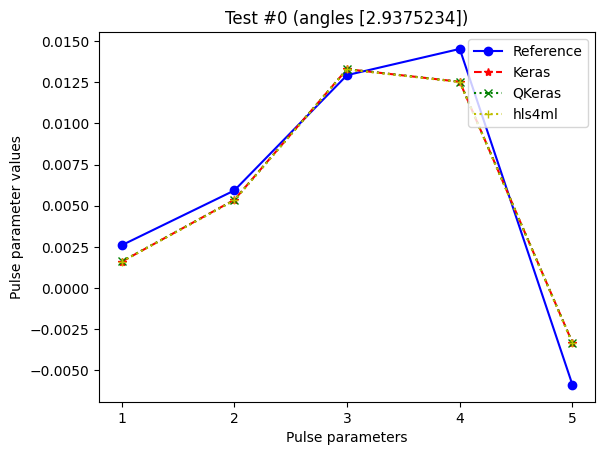

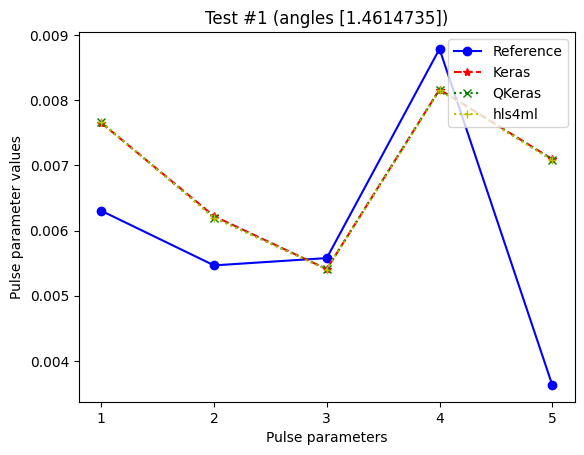

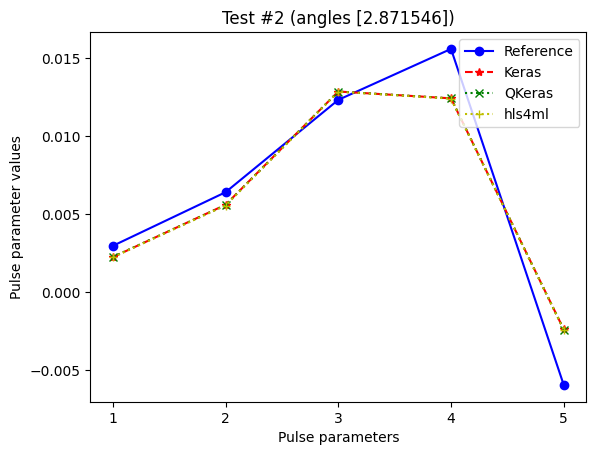

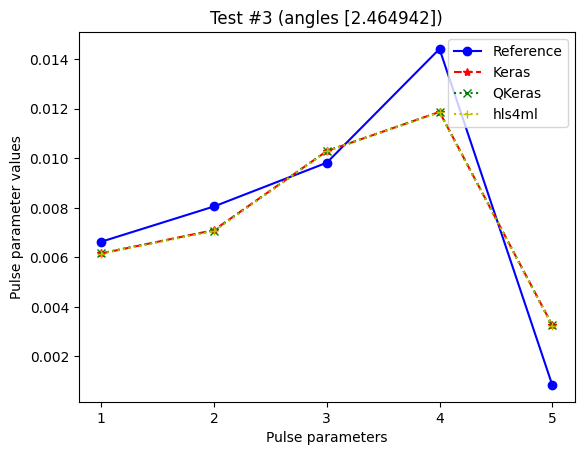

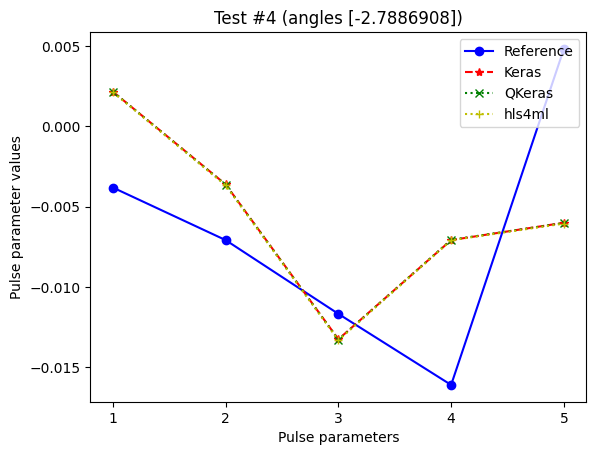

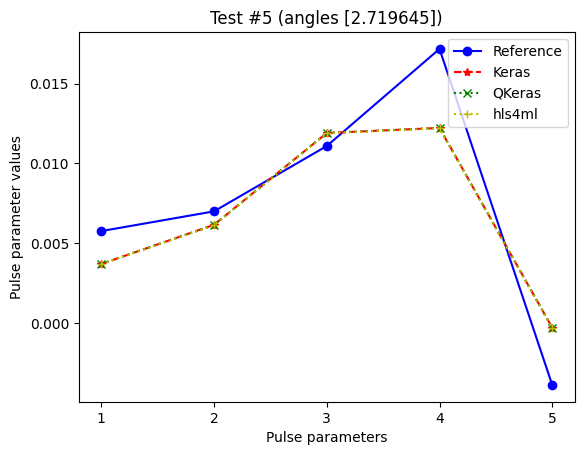

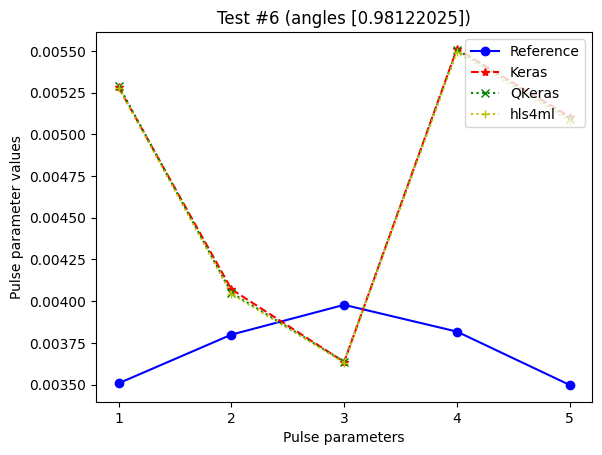

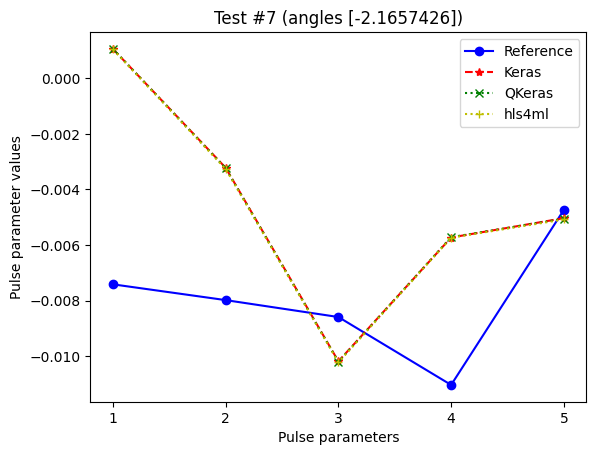

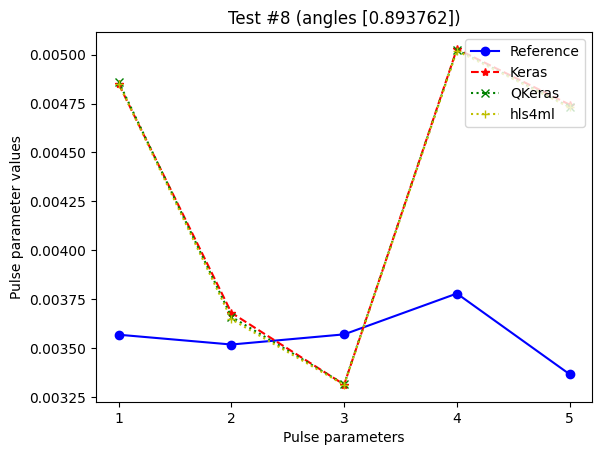

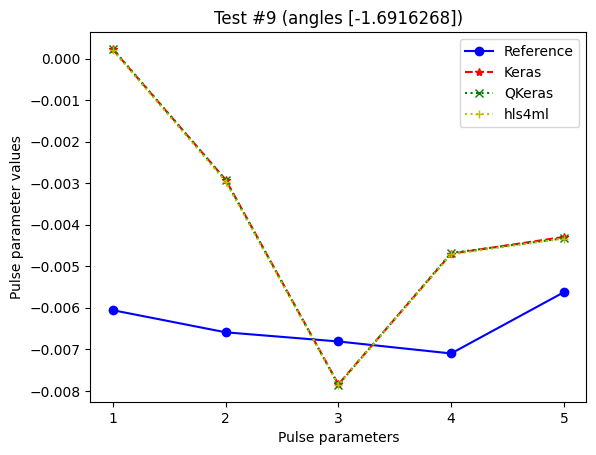

In [47]:
x = np.arange(1, y_test.shape[1]+1, 1)
for i in range(10):#Y_test.shape[0]):
    plt.clf()
    #plt.rcParams["figure.figsize"] = (10,5)
    plt.plot(x, y_test[i], marker='o', linestyle='-', color='b') 
    plt.plot(x, y_keras[i], marker='*', linestyle='--', color='r')
    plt.plot(x, y_qkeras[i], marker='x', linestyle=':', color='g')
    plt.plot(x, y_hls4ml[i], marker='+', linestyle=':', color='y')
    plt.xticks(x, x)
    plt.legend(['Reference', 'Keras', 'QKeras','hls4ml'], loc='upper right')
    plt.ylabel('Pulse parameter values')
    plt.xlabel('Pulse parameters')
    plt.title('Test #{} (angles {})'.format(i, x_test[i]))
    #plt.ylim([min_pparam_value, max_pparam_value])
    plt.show()

### Pulse

In [48]:
if PULSE_ENABLED:
    plot_ugate_pulse(x_test.values[0], y_test.to_numpy()[0], verbose=False)

In [49]:
if PULSE_ENABLED:
    plot_ugate_pulse(x_test.values[0], y_keras[0], verbose=False)

In [50]:
if PULSE_ENABLED:
    plot_ugate_pulse(x_test.values[0], y_qkeras[0], verbose=False)

In [51]:
if PULSE_ENABLED:
    plot_ugate_pulse(x_test.values[0], y_hls4ml[0], verbose=False)